# Um olhar sobre a performance das salas de cinema no Brasil e suas preferências de consumo - Dados de 2009 a 2017"

## Análise Exploratória

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import catboost
import ydata_profiling as yp

from matplotlib.ticker import FuncFormatter

---

## Limpeza e Preparação

In [2]:
df_salas_exib = pd.read_csv('SalasDeExibicaoEComplexos.csv')
df_salas_exib.head(5)
df_salas_exib_clean = df_salas_exib[['NOME_SALA', 'REGISTRO_SALA', 'SITUACAO_SALA',
       'ASSENTOS_SALA', 'NOME_COMPLEXO', 'REGISTRO_COMPLEXO',
       'MUNICIPIO_COMPLEXO', 'UF_COMPLEXO',
       'COMPLEXO_ITINERANTE', 'OPERACAO_USUAL', 'EXIBIDOR',
       'SITUACAO_EXIBIDOR','GRUPO_EXIBIDOR']]

#-----------------------------------------------------------

df_bilheteria = pd.read_csv('BilheteriaObrasSemana.csv')
df_bilheteria


def to_datetime_year(df, coluna, date_format):
    df[coluna] = pd.to_datetime(df[coluna], format=date_format).dt.year

to_datetime_year(df_bilheteria, 'ANO_CINEMATOGRAFICO', '%Y-%m-%d')


def to_datetime(df, coluna, date_format):
    df[coluna] = pd.to_datetime(df[coluna], format=date_format)

to_datetime(df_bilheteria, 'DT_FIM_EXIBICAO', '%Y-%m-%d')
to_datetime(df_bilheteria, 'DT_INICIO_EXIBICAO', '%Y-%m-%d')


#-----------------------------------------------------------

df_ag_econ = pd.read_csv('AgentesEconomicosRegulares.csv')
df_ag_econ

def to_datetime(df, coluna, date_format):
    df[coluna] = pd.to_datetime(df[coluna], format=date_format)

to_datetime(df_ag_econ, 'DATA_REGISTRO', '%Y-%m-%d')


#------------------------------------------------------------



Gráfico indica flutuação nas somatórias das salas de cinema por país de origem da obra

In [3]:
df_bilheteria_plot1 = df_bilheteria[['TITULO_ORIGINAL', 'SALAS', 'DT_INICIO_EXIBICAO', 'DT_FIM_EXIBICAO', 'PUBLICO', 'RENDA']]

soma_salas_pais = df_bilheteria['PAIS_ORIGEM'].str.split(',', expand=True)
soma_salas_pais = soma_salas_pais[[0, 1]]
soma_salas_pais.rename(columns={0:'PAIS_ORIGEM', 1:'COPRODUCAO_BRASILEIRA'}, inplace=True)
soma_salas_pais.head(20)

soma_salas_pais['COPRODUCAO_BRASILEIRA'] = soma_salas_pais['COPRODUCAO_BRASILEIRA'].apply(lambda x: 1 if x == ' Brasil' else 0)
soma_salas_pais['COPRODUCAO_BRASILEIRA'].value_counts()

df_bilheteria_plot1 = pd.concat([df_bilheteria_plot1, soma_salas_pais], axis=1)
df_bilheteria_plot1

# dias_cartaz = 
df_bilheteria_plot1['TEMPO_CARTAZ'] = df_bilheteria_plot1['DT_FIM_EXIBICAO'] - df_bilheteria_plot1['DT_INICIO_EXIBICAO']

df_bilheteria_plot1 = df_bilheteria_plot1[['TITULO_ORIGINAL', 'PAIS_ORIGEM', 'COPRODUCAO_BRASILEIRA', 'SALAS', 'PUBLICO', 'RENDA', 'DT_INICIO_EXIBICAO', 'DT_FIM_EXIBICAO']]
df_bilheteria_plot1


,TITULO_ORIGINAL,PAIS_ORIGEM,COPRODUCAO_BRASILEIRA,SALAS,PUBLICO,RENDA,DT_INICIO_EXIBICAO,DT_FIM_EXIBICAO
0,COLLEGE,Estados Unidos,0,8,833,5325.00,2009-01-02,2009-01-08
1,O ABORTO DOS OUTROS,Brasil,0,1,40,196.00,2009-01-02,2009-01-08
2,ONDE ANDARÁ DULCE VEIGA?,Brasil,0,1,66,210.00,2009-01-02,2009-01-08
3,QUAND J'ETAIS CHANTEUR,França,0,1,103,842.92,2009-01-02,2009-01-08
4,REC,Espanha,0,2,252,1575.00,2009-01-02,2009-01-08
...,...,...,...,...,...,...,...,...
51171,BELLE DE JOUR,França,0,4,218,3058.00,2017-12-28,2018-01-03
51172,BLOW-UP,Estados Unidos,0,1,16,80.00,2017-12-28,2018-01-03
51173,COLO,Portugal,0,2,60,464.00,2017-12-28,2018-01-03
51174,"GRADUATE, THE",Estados Unidos,0,1,12,96.00,2017-12-28,2018-01-03


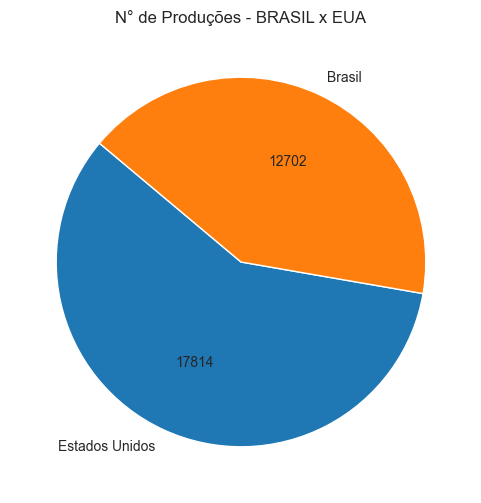

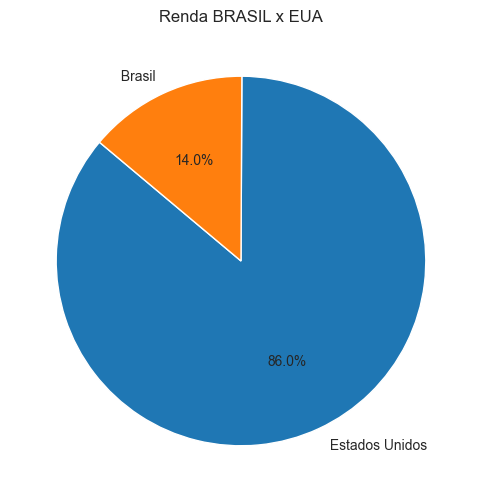

In [4]:

#PLOT N° DE PRODUÇÔES BRAxEUA
sum_eua = (df_bilheteria_plot1['PAIS_ORIGEM'] == ' Estados Unidos').sum()
sum_bra = (df_bilheteria_plot1['PAIS_ORIGEM'] == ' Brasil').sum()

total_productions = sum_eua + sum_bra

#Calcular Porcentagem de produções
percentage_eua = (sum_eua / total_productions) * 100
percentage_bra = (sum_bra / total_productions) * 100

# Criar plot
countries = ['Estados Unidos', 'Brasil']
percentages = [sum_eua, sum_bra]
colors = ['blue', 'green']

plt.figure(figsize=(6, 6))
plt.pie(percentages, labels=countries, autopct=lambda p: '{:.0f}'.format(p * total_productions / 100), startangle=140)
plt.title('N° de Produções - BRASIL x EUA')
plt.axis()
plt.show()

#PLOT RENDA BRAxEUA
df_plot = df_bilheteria_plot1[['PAIS_ORIGEM', 'RENDA']]

# Agrupar e calcular a somatória da RENDA por país
grouped_data = df_plot.groupby('PAIS_ORIGEM').sum()

# Ordenar por RENDA
countries_renda = grouped_data.sort_values(by='RENDA', ascending=False).head(2)

# Criar Pie Plot
plt.figure(figsize=(6, 6))
plt.pie(countries_renda['RENDA'], labels=countries_renda.index, autopct='%1.1f%%', startangle=140)
plt.title('Renda BRASIL x EUA')
plt.axis()
plt.show()



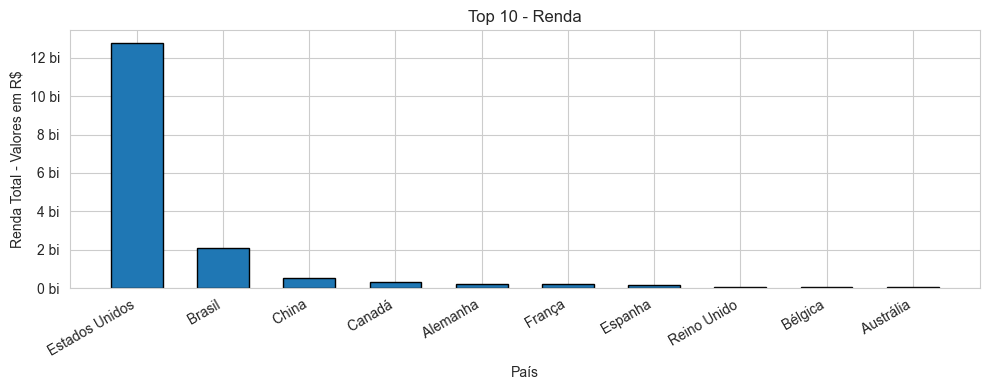

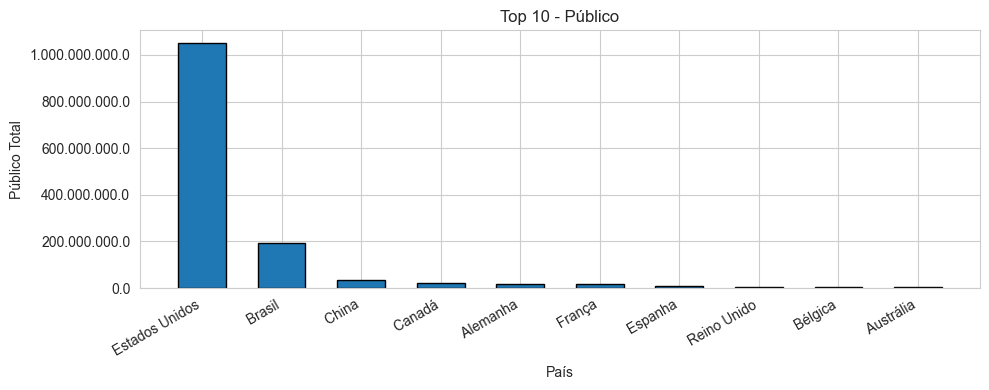

In [5]:

df_plot = df_bilheteria_plot1[['PAIS_ORIGEM', 'SALAS', 'PUBLICO', 'RENDA']]

def group_and_plot(coluna):

    if coluna == 'RENDA':
        grouped_data = df_plot.groupby('PAIS_ORIGEM').sum()
        top_10 = grouped_data.sort_values(by=coluna, ascending=False).head(10)

        # Create the bar plot
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(top_10.index, top_10[coluna]/1000000000, width=0.6, edgecolor='black')
        ax.set_title(f'Top 10 - Renda')
        ax.set_xlabel('País')
        ax.set_ylabel('Renda Total - Valores em R$')

        def currency_formatter(x, pos):
            return "{:.0f} bi".format(x)

        ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

    elif coluna == 'PUBLICO':
        grouped_data = df_plot.groupby('PAIS_ORIGEM').sum()
        top_10 = grouped_data.sort_values(by=coluna, ascending=False).head(10)

        # Create the bar plot
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(top_10.index, top_10[coluna], width=0.6, edgecolor='black')
        ax.set_title(f'Top 10 - Público')
        ax.set_xlabel('País')
        ax.set_ylabel('Público Total')

        def people_formatter(x, pos):
            return "{:,.1f}".format(x).replace(",", ".")

        ax.yaxis.set_major_formatter(FuncFormatter(people_formatter))

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

# Call the function for each statistic
group_and_plot('RENDA')  # Top 10 Países com maior RENDA
group_and_plot('PUBLICO')  # Top 10 Países com maior PUBLICO


In [6]:

# # Group by 'PAIS_ORIGEM' and calculate the sum of 'SALAS', 'PUBLICO', and 'RENDA' for each country
# grouped_data = df.groupby('PAIS_ORIGEM').sum()

# # Sort the data by 'RENDA' in descending order and select the top 10 countries
# top_10_countries_renda = grouped_data.sort_values(by='RENDA', ascending=False).head(10)
# top_10_countries_salas = grouped_data.sort_values(by='SALAS', ascending=False).head(10)
# top_10_countries_publico = grouped_data.sort_values(by='PUBLICO', ascending=False).head(10)

# # Create subplots for each country's statistics
# fig, axes = plt.subplots(3, 1, figsize=(12, 8))
# axes = axes.ravel()

# def plot(df, coluna):
#     for idx, (country, stats) in enumerate(df.iterrows()):
#         axes[idx].bar([coluna], stats, width=0.6, edgecolor='black')
#         axes[idx].set_title(country)
#         axes[idx].set_xlabel('Statistics')
#         axes[idx].set_ylabel('Counts')
#         axes[idx].set_xticks([])  # Remove x ticks for cleaner visualization

#     # Hide any remaining empty subplots
#     for idx in range(len(df), len(axes)):
#         axes[idx].axis('off')

# plot(top_10_countries_renda, 'RENDA')
# plot(top_10_countries_publico, 'PUBLICO')
# plot(top_10_countries_salas, 'SALAS')

# plt.tight_layout()
# plt.show()

In [7]:

# Convert 'DT_INICIO_EXIBICAO' and 'DT_FIM_EXIBICAO' columns to strings
df_bilheteria_plot1['DT_INICIO_EXIBICAO'] = df_bilheteria_plot1['DT_INICIO_EXIBICAO'].astype(str)
df_bilheteria_plot1['DT_FIM_EXIBICAO'] = df_bilheteria_plot1['DT_FIM_EXIBICAO'].astype(str)

# Filter the DataFrame to only the required columns
df_bilheteria_plot1 = df_bilheteria_plot1[['TITULO_ORIGINAL', 'PAIS_ORIGEM', 'SALAS', 'PUBLICO', 'RENDA', 'DT_INICIO_EXIBICAO', 'DT_FIM_EXIBICAO']]

# Create the plot
X_data = df_bilheteria_plot1[df_bilheteria_plot1['PAIS_ORIGEM']]
y_data = df_bilheteria_plot1['SALAS']

fig, ax = plt.subplots()
ax.bar(X_data, y_data, width=0.8, edgecolor="white", linewidth=0.7)

ax.set(title='Fluctuation in Total Cinemas (SALAS) by Country of Origin',
       xlabel='Country of Origin (PAIS_ORIGEM)',
       ylabel='Total Cinemas (SALAS)')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

KeyError: "None of [Index([' Estados Unidos', ' Brasil', ' Brasil', ' França', ' Espanha',\n       ' Estados Unidos', ' Brasil', ' Estados Unidos', ' Estados Unidos',\n       ' Brasil',\n       ...\n       ' Argentina', ' Estados Unidos', ' China', ' Bélgica',\n       ' Estados Unidos', ' França', ' Estados Unidos', ' Portugal',\n       ' Estados Unidos', ' França'],\n      dtype='object', length=51176)] are in the [columns]"

In [ ]:

#Somando salas e publicos por país

pais_salas = df_bilheteria_plot1.groupby('PAIS_ORIGEM')['SALAS'].sum()
pais_salas

plt.figure(figsize=(10, 6))
pais_salas.plot(kind='bar', color='skyblue')
plt.title('Fluctuation in Total Cinemas (SALAS) by Country of Origin')
plt.xlabel('Country of Origin (PAIS_ORIGEM)')
plt.ylabel('Total Cinemas (SALAS)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:

X = df_bilheteria['GENERO']
Y = df_bilheteria['PUBLICO']

sizes = np.random.uniform(15, 80, len(Y))
colors = np.random.uniform(15, 80, len(Y))

fig, ax = plt.subplots()

ax.scatter(X, Y, s=sizes, c=colors, vmin=0, vmax=100)

plt.show()

NameError: name 'df_bilheteria' is not defined

---